# Training FSRS on simulated data

Requirement: fsrs-optimizer >= 6.1.4

In [1]:
import numpy as np
import pandas as pd

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    0.4783,
    1.2172,
    9.7398,
    15.8796,
    6.8942,
    0.3659,
    3.2729,
    0.0099,
    1.4107,
    0.0061,
    0.5899,
    1.68,
    0.009,
    0.4049,
    1.2676,
    0.0,
    3.0064,
    0.3535,
    0.5764,
    0.2246,
    0.2205,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        learn_span=learn_span,
        learning_step_count=0,
        relearning_step_count=0,
        fuzz=True,
    )

    flattened_revlogs = []

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt


def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(gamma=0, verbose=False)
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, optimizer.w):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset

def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30
sample size: 2795


  0%|          | 0/2795 [00:00<?, ?it/s]

loss before: 0.3363, loss after: 0.3166
RMSE(bins): 0.0376
AUC: 0.6254
0.4783 -> 0.4443: SMAPE=7.3705%
1.2172 -> 0.8456: SMAPE=36.0287%
9.7398 -> 11.3092: SMAPE=14.9119%
15.8796 -> 18.7304: SMAPE=16.4739%
6.8942 -> 6.6052: SMAPE=4.2817%
0.3659 -> 0.6091: SMAPE=49.8872%
3.2729 -> 3.3155: SMAPE=1.2932%
0.0099 -> 0.0102: SMAPE=2.9851%
1.4107 -> 1.6536: SMAPE=15.8535%
0.0061 -> 0.4241: SMAPE=194.3282%
0.5899 -> 0.5916: SMAPE=0.2878%
1.68 -> 1.5722: SMAPE=6.6294%
0.009 -> 0.0326: SMAPE=113.4615%
0.4049 -> 0.4133: SMAPE=2.0533%
1.2676 -> 1.5964: SMAPE=22.9609%
0.0 -> 0.2025: SMAPE=200.0000%
3.0064 -> 1.7184: SMAPE=54.5208%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1665: SMAPE=27.9070%
Avg. SMAPE: 60.9810%
loss before: 0.3363, loss after: 0.3173
RMSE(bins): 0.0390
AUC: 0.6226
--------------------------------
learn_span: 60
sample size: 6223


  0%|          | 0/6223 [00:00<?, ?it/s]

loss before: 0.3530, loss after: 0.3359
RMSE(bins): 0.0249
AUC: 0.5872
0.4783 -> 0.4426: SMAPE=7.7533%
1.2172 -> 0.9884: SMAPE=20.7472%
9.7398 -> 9.5638: SMAPE=1.8235%
15.8796 -> 16.7433: SMAPE=5.2951%
6.8942 -> 6.5718: SMAPE=4.7884%
0.3659 -> 0.5974: SMAPE=48.0639%
3.2729 -> 3.3269: SMAPE=1.6364%
0.0099 -> 0.0018: SMAPE=138.4615%
1.4107 -> 1.6549: SMAPE=15.9316%
0.0061 -> 0.4159: SMAPE=194.2180%
0.5899 -> 0.6224: SMAPE=5.3617%
1.68 -> 1.5378: SMAPE=8.8383%
0.009 -> 0.0797: SMAPE=159.4138%
0.4049 -> 0.4013: SMAPE=0.8931%
1.2676 -> 1.6208: SMAPE=24.4564%
0.0 -> 0.0453: SMAPE=200.0000%
3.0064 -> 1.6827: SMAPE=56.4586%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1123: SMAPE=65.0240%
Avg. SMAPE: 69.9301%
loss before: 0.3530, loss after: 0.3363
RMSE(bins): 0.0267
AUC: 0.5848
--------------------------------
learn_span: 120
sample size: 13274


  0%|          | 0/13274 [00:00<?, ?it/s]

loss before: 0.3507, loss after: 0.3370
RMSE(bins): 0.0211
AUC: 0.5768
0.4783 -> 0.407: SMAPE=16.1075%
1.2172 -> 1.2579: SMAPE=3.2888%
9.7398 -> 8.4348: SMAPE=14.3607%
15.8796 -> 11.9985: SMAPE=27.8434%
6.8942 -> 6.4394: SMAPE=6.8219%
0.3659 -> 0.4336: SMAPE=16.9356%
3.2729 -> 3.3878: SMAPE=3.4501%
0.0099 -> 0.0014: SMAPE=150.4425%
1.4107 -> 1.6377: SMAPE=14.8931%
0.0061 -> 0.1907: SMAPE=187.6016%
0.5899 -> 0.6267: SMAPE=6.0496%
1.68 -> 1.5433: SMAPE=8.4820%
0.009 -> 0.1462: SMAPE=176.8041%
0.4049 -> 0.5022: SMAPE=21.4530%
1.2676 -> 1.5992: SMAPE=23.1338%
0.0 -> 0.0137: SMAPE=200.0000%
3.0064 -> 2.1052: SMAPE=35.2610%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1259: SMAPE=54.6189%
Avg. SMAPE: 70.3292%
loss before: 0.3507, loss after: 0.3372
RMSE(bins): 0.0224
AUC: 0.5736
--------------------------------
learn_span: 240
sample size: 27831


  0%|          | 0/27831 [00:00<?, ?it/s]

loss before: 0.3482, loss after: 0.3344
RMSE(bins): 0.0166
AUC: 0.5586
0.4783 -> 0.3013: SMAPE=45.4079%
1.2172 -> 1.1748: SMAPE=3.5452%
9.7398 -> 9.987: SMAPE=2.5062%
15.8796 -> 13.1466: SMAPE=18.8313%
6.8942 -> 6.5118: SMAPE=5.7049%
0.3659 -> 0.3827: SMAPE=4.4884%
3.2729 -> 3.534: SMAPE=7.6716%
0.0099 -> 0.0088: SMAPE=11.7647%
1.4107 -> 1.5855: SMAPE=11.6681%
0.0061 -> 0.1084: SMAPE=178.6900%
0.5899 -> 0.5986: SMAPE=1.4640%
1.68 -> 1.5291: SMAPE=9.4045%
0.009 -> 0.2183: SMAPE=184.1619%
0.4049 -> 0.5655: SMAPE=33.0998%
1.2676 -> 1.6853: SMAPE=28.2908%
0.0 -> 0.0022: SMAPE=200.0000%
3.0064 -> 2.2623: SMAPE=28.2461%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1002: SMAPE=75.0234%
Avg. SMAPE: 64.7302%
loss before: 0.3482, loss after: 0.3347
RMSE(bins): 0.0168
AUC: 0.5561
--------------------------------
learn_span: 480
sample size: 57373


  0%|          | 0/57373 [00:00<?, ?it/s]

loss before: 0.3424, loss after: 0.3302
RMSE(bins): 0.0127
AUC: 0.5503
0.4783 -> 0.3731: SMAPE=24.7122%
1.2172 -> 1.5716: SMAPE=25.4159%
9.7398 -> 9.6306: SMAPE=1.1275%
15.8796 -> 13.8136: SMAPE=13.9156%
6.8942 -> 6.7278: SMAPE=2.4431%
0.3659 -> 0.1495: SMAPE=83.9736%
3.2729 -> 3.615: SMAPE=9.9334%
0.0099 -> 0.0161: SMAPE=47.6923%
1.4107 -> 1.499: SMAPE=6.0694%
0.0061 -> 0.0343: SMAPE=139.6040%
0.5899 -> 0.6034: SMAPE=2.2626%
1.68 -> 1.5252: SMAPE=9.6593%
0.009 -> 0.1952: SMAPE=182.3702%
0.4049 -> 0.5209: SMAPE=25.0594%
1.2676 -> 1.7945: SMAPE=34.4143%
0.0 -> 0.0185: SMAPE=200.0000%
3.0064 -> 2.8034: SMAPE=6.9882%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1006: SMAPE=74.6808%
Avg. SMAPE: 66.6518%
loss before: 0.3424, loss after: 0.3304
RMSE(bins): 0.0124
AUC: 0.5525
--------------------------------
learn_span: 960
sample size: 117401


  0%|          | 0/117401 [00:00<?, ?it/s]

loss before: 0.3414, loss after: 0.3305
RMSE(bins): 0.0107
AUC: 0.5415
0.4783 -> 0.3964: SMAPE=18.7264%
1.2172 -> 1.4322: SMAPE=16.2301%
9.7398 -> 10.8015: SMAPE=10.3372%
15.8796 -> 14.763: SMAPE=7.2879%
6.8942 -> 6.8292: SMAPE=0.9473%
0.3659 -> 0.0367: SMAPE=163.5370%
3.2729 -> 3.5135: SMAPE=7.0907%
0.0099 -> 0.0168: SMAPE=51.6854%
1.4107 -> 1.3339: SMAPE=5.5964%
0.0061 -> 0.0142: SMAPE=79.8030%
0.5899 -> 0.6694: SMAPE=12.6261%
1.68 -> 1.5537: SMAPE=7.8115%
0.009 -> 0.1707: SMAPE=179.9666%
0.4049 -> 0.4679: SMAPE=14.4363%
1.2676 -> 2.569: SMAPE=67.8413%
0.0 -> 0.0487: SMAPE=200.0000%
3.0064 -> 2.9772: SMAPE=0.9760%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1: SMAPE=75.1950%
Avg. SMAPE: 68.0695%
loss before: 0.3414, loss after: 0.3306
RMSE(bins): 0.0105
AUC: 0.5441
--------------------------------


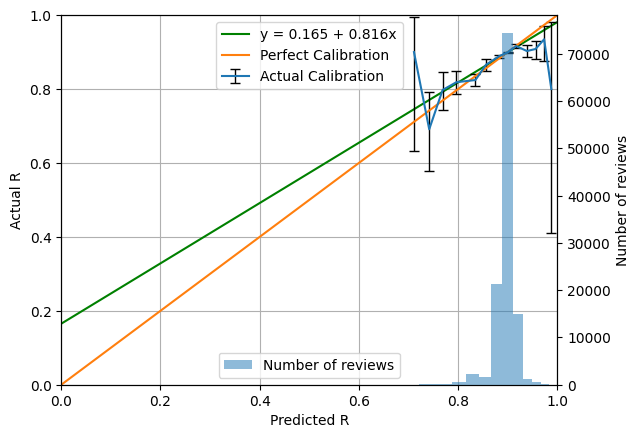

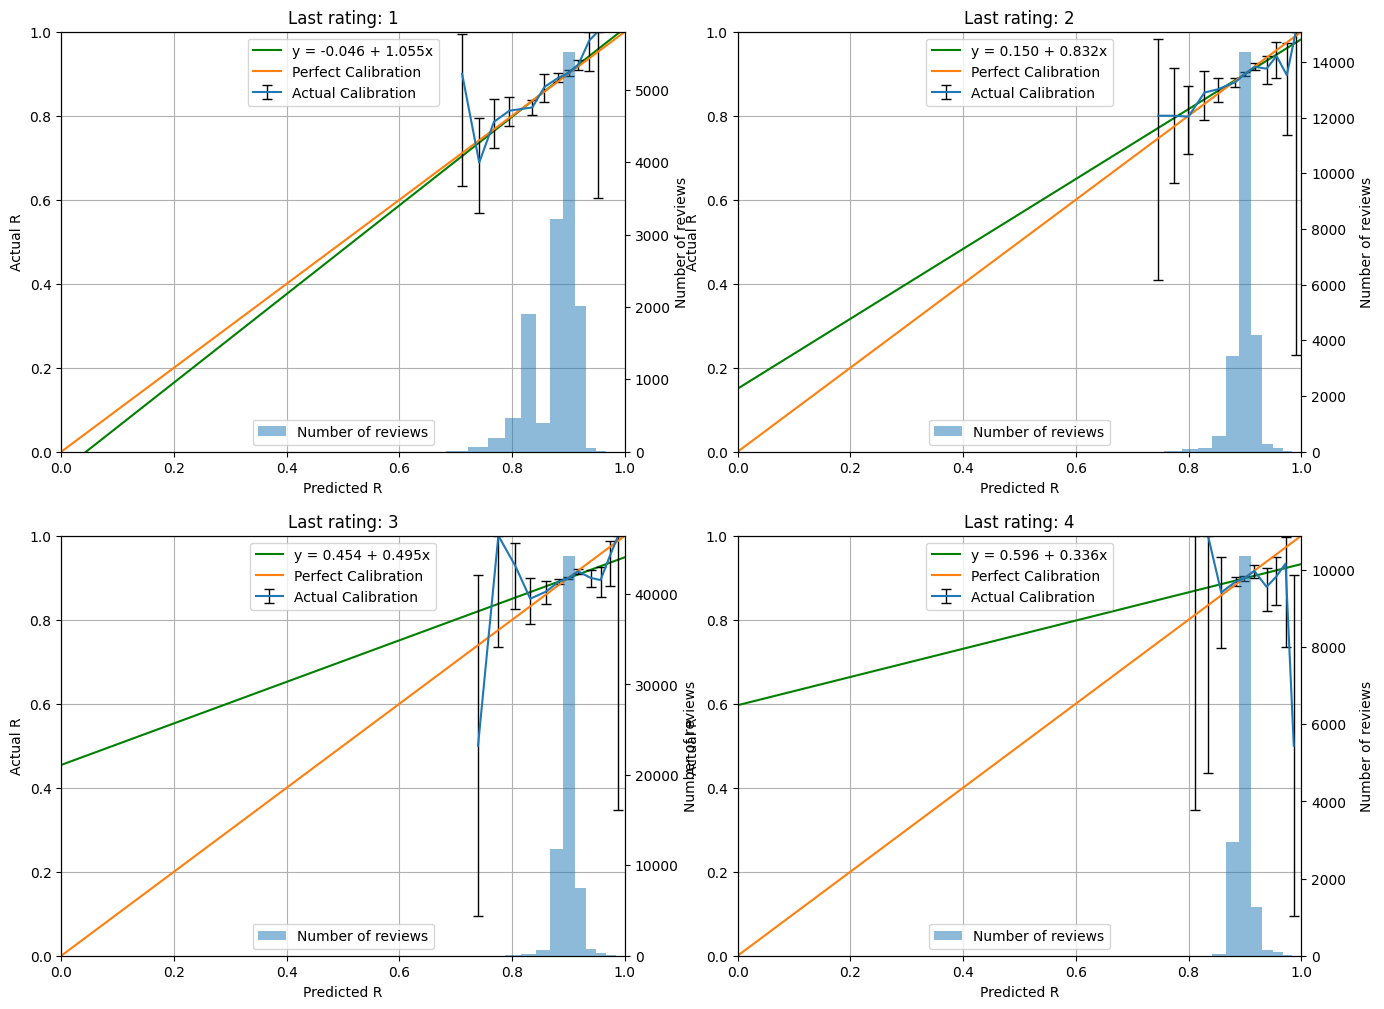

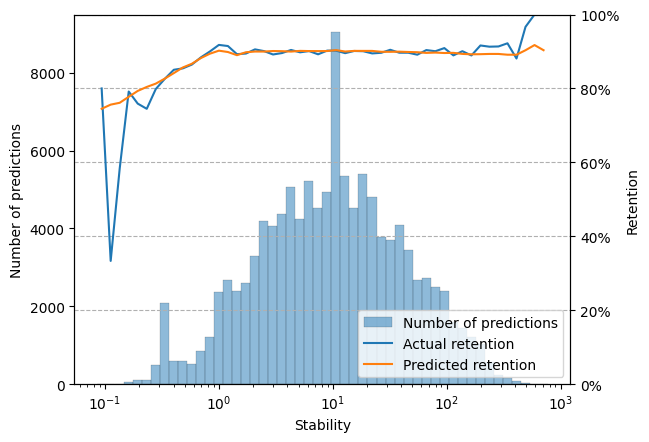

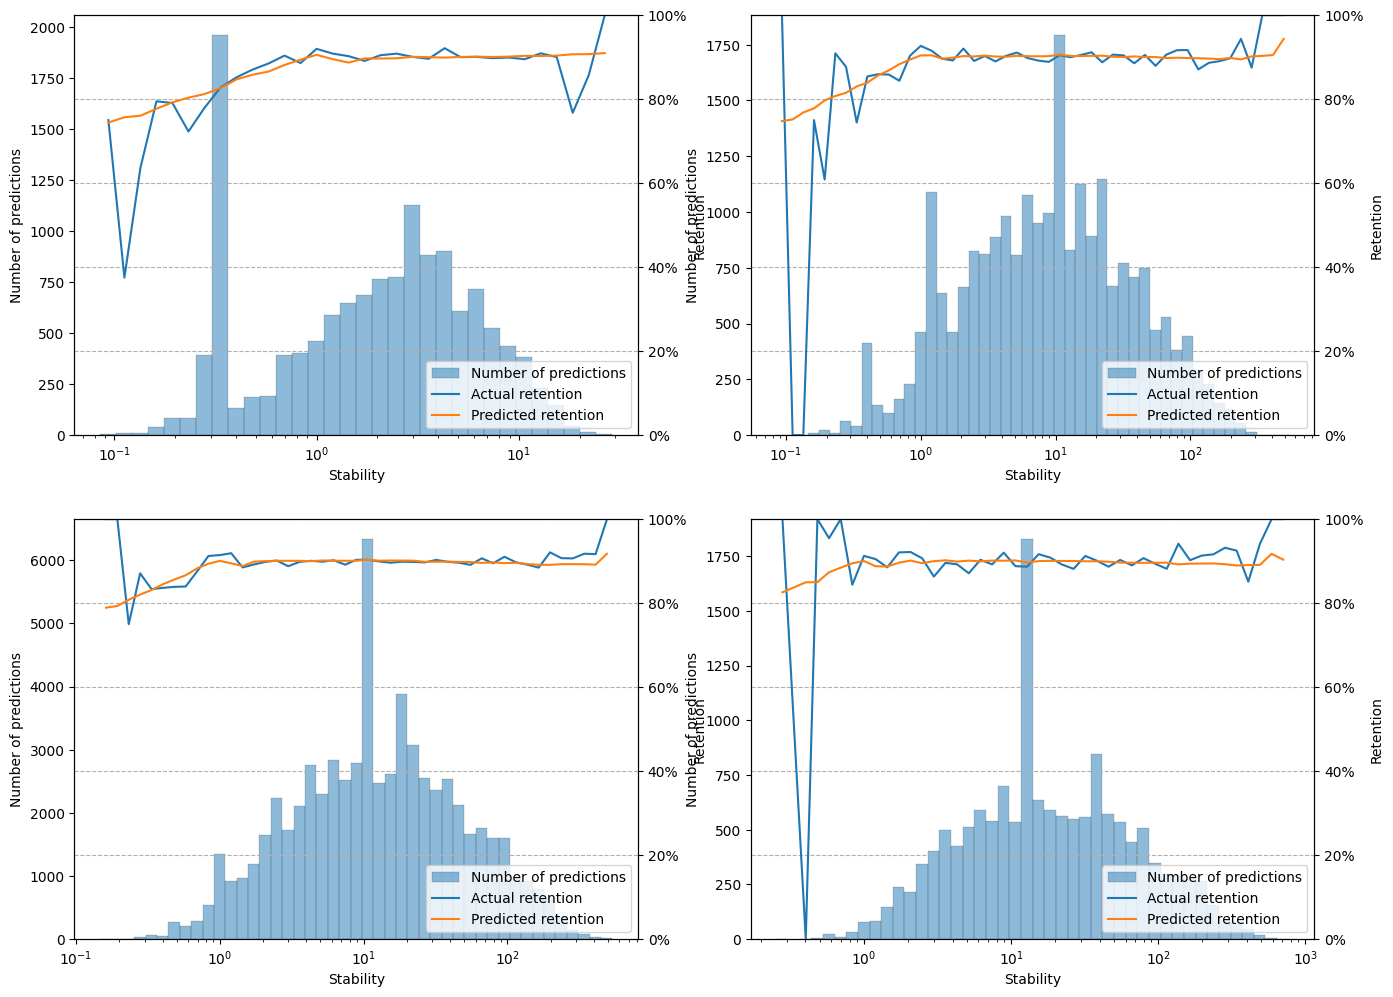

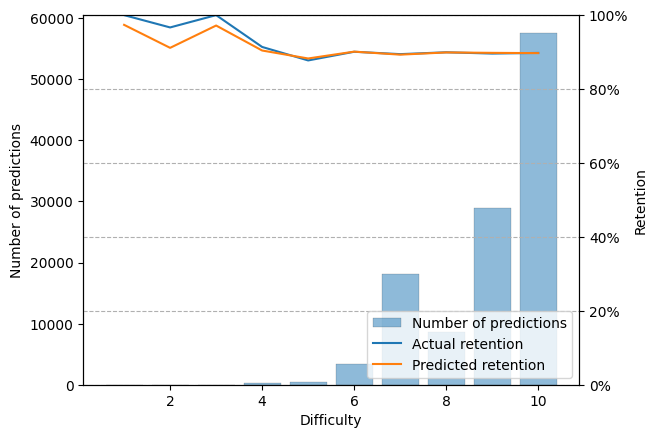

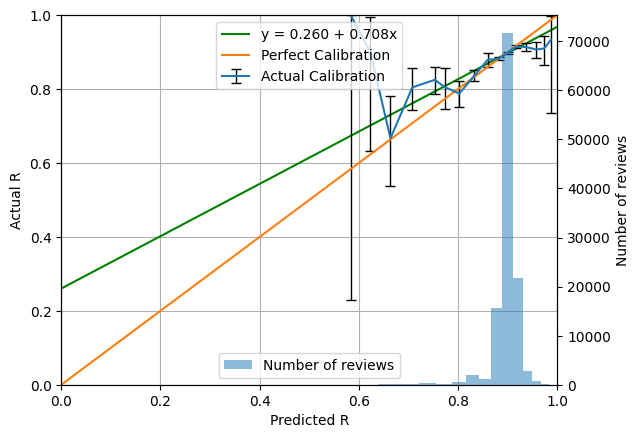

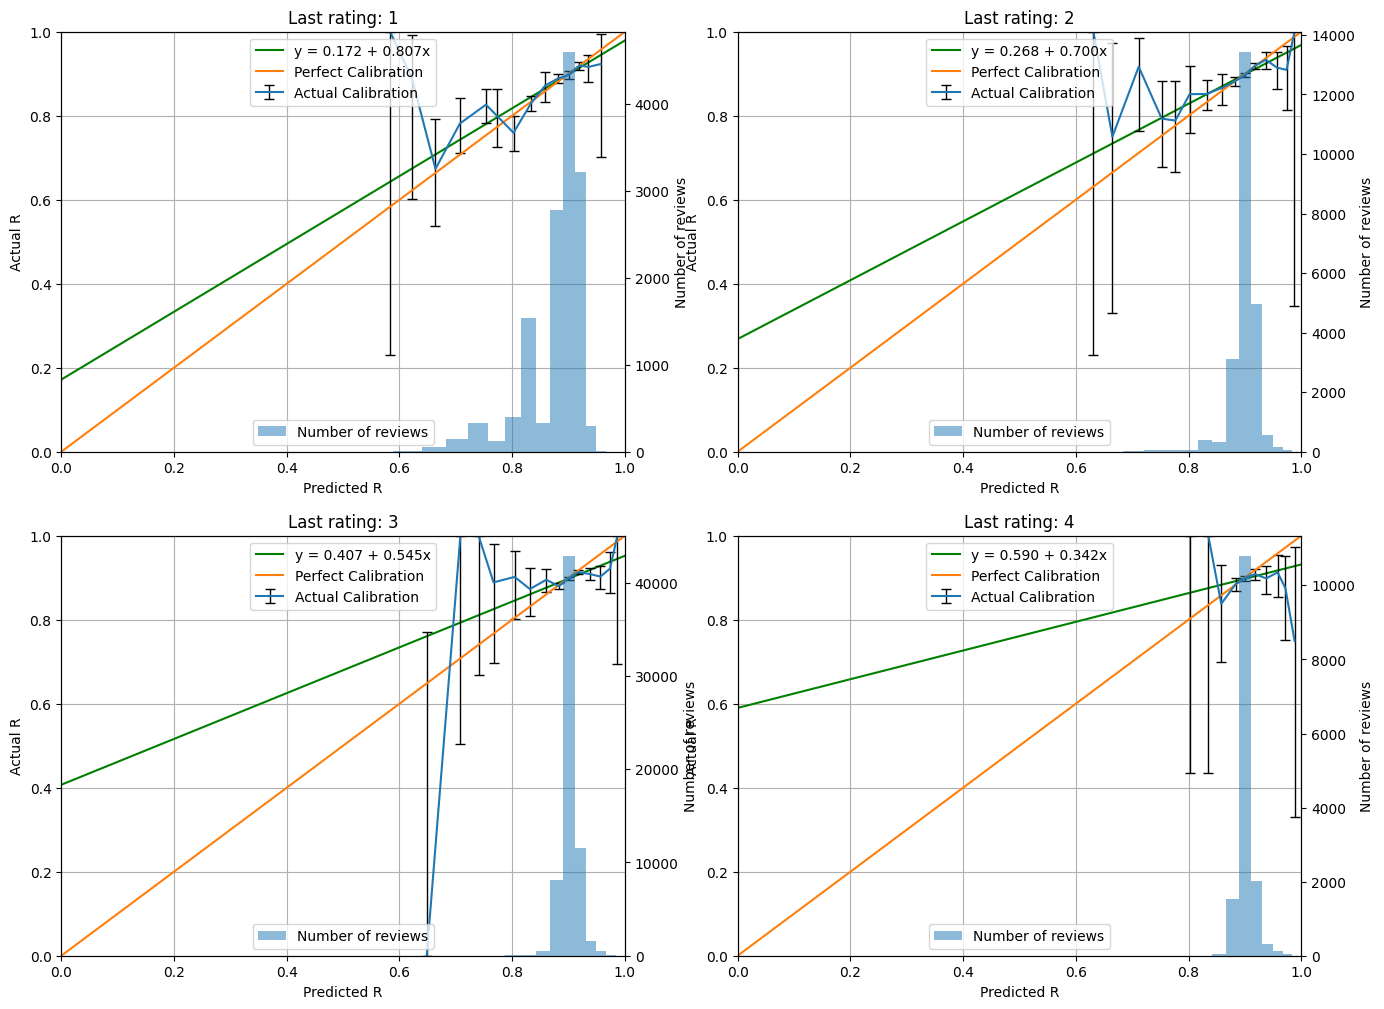

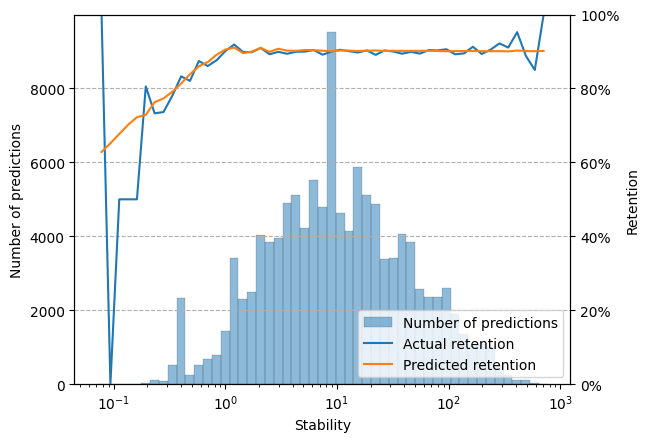

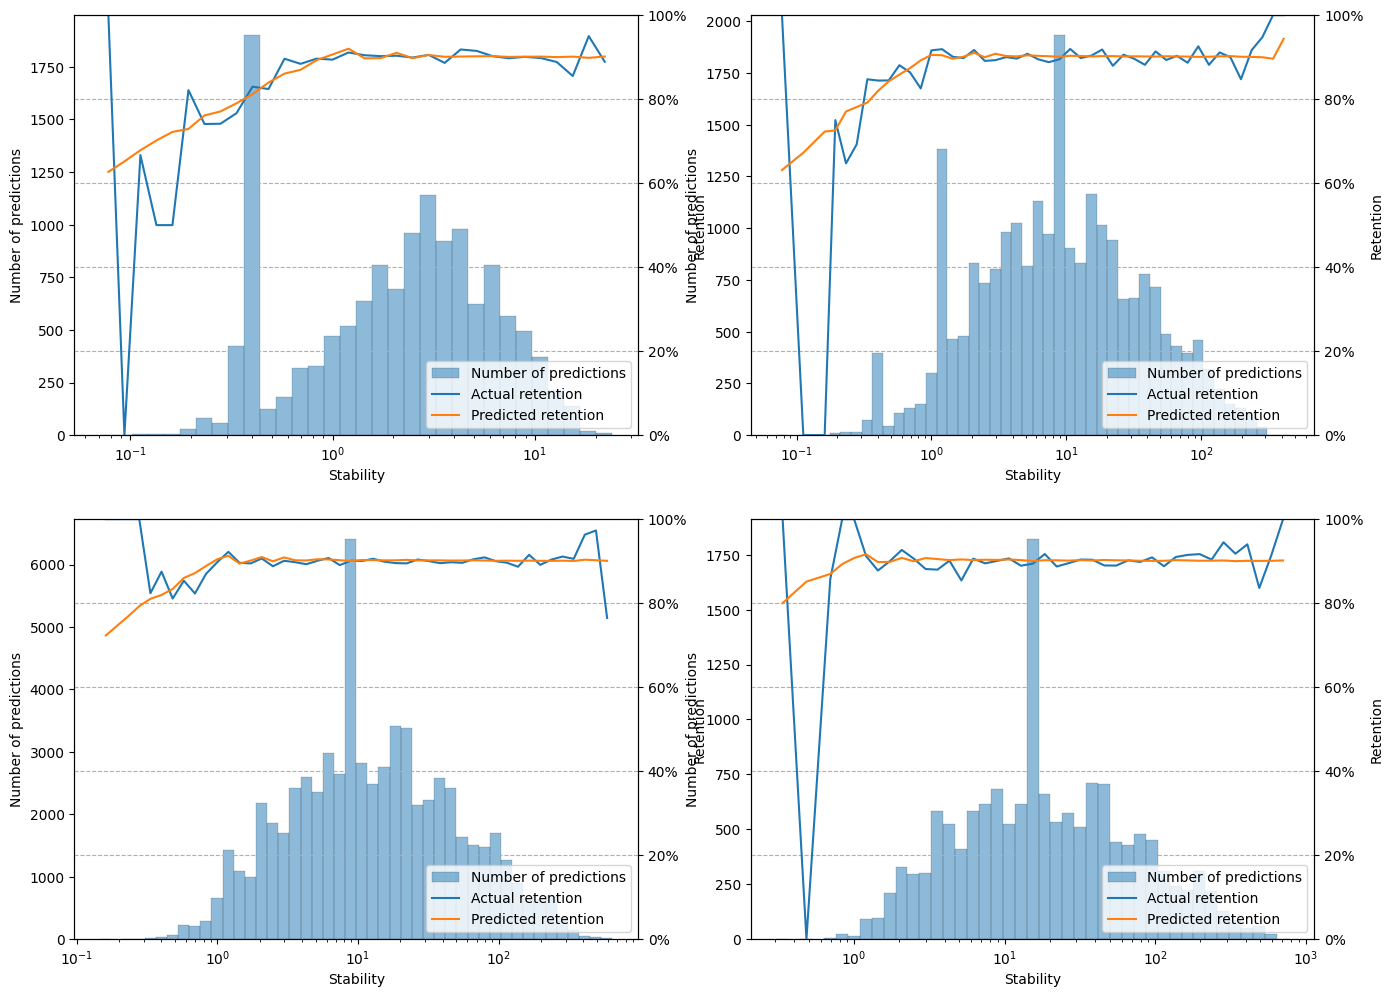

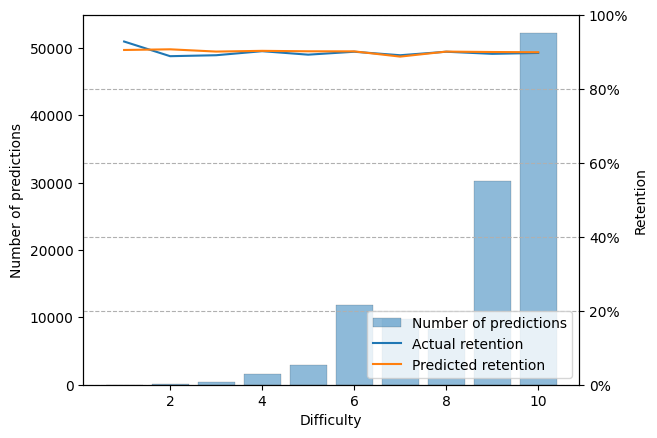

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

In [5]:
np.set_printoptions(precision=6, suppress=True)
print(f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}")
print(f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}")
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.000688 -0.000358 -0.00027  -0.000305 -0.000116 -0.00015 ]
RMSE(bins) (trained - ideal): [-0.001468 -0.001765 -0.001357 -0.000235  0.000282  0.000126]
AUC (trained - ideal): [ 0.002758  0.002464  0.003175  0.002494 -0.002231 -0.002632]


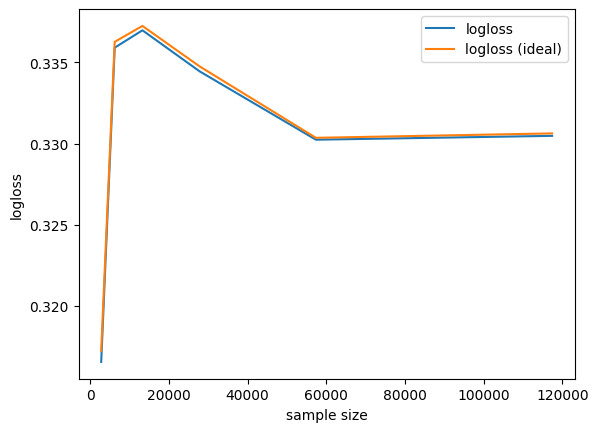

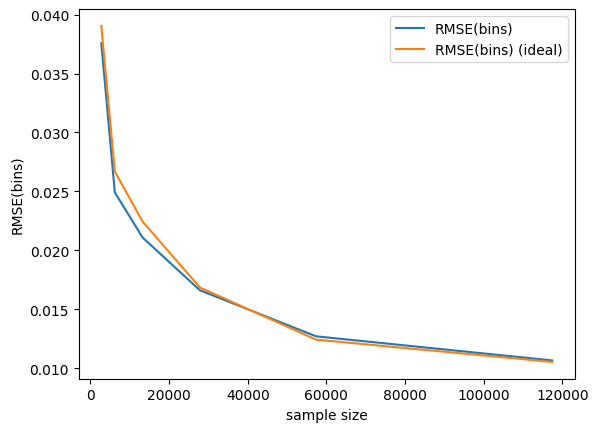

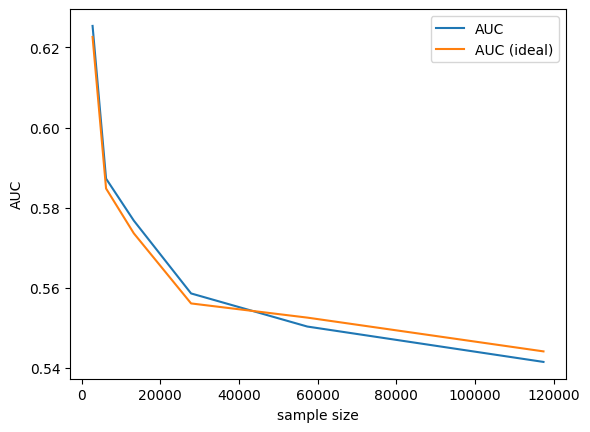

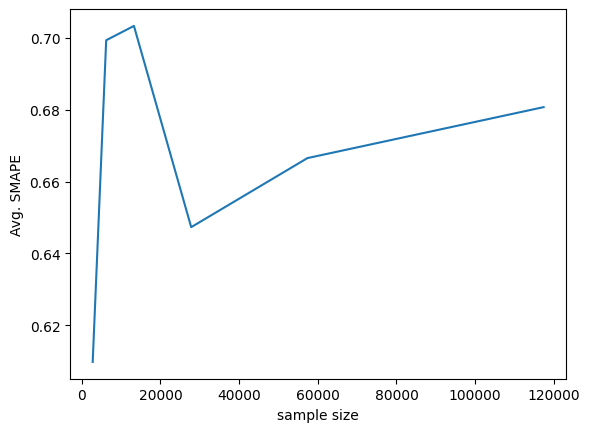

In [6]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()
